In [1]:
#https://data.boston.gov/dataset/crime-incident-reports-august-2015-to-date-source-new-system/resource/12cb3883-56f5-47de-afa5-3b1cf61b257b
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from geopy.distance import distance

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

import seaborn as sns

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

%matplotlib inline

In [11]:
!wget -q -O BostonCrimeIncidents.csv https://data.boston.gov/dataset/6220d948-eae2-4e4b-8723-2dc8e67722a3/resource/12cb3883-56f5-47de-afa5-3b1cf61b257b/download/tmpq6ct7vhf.csv
print('Data downloaded!')

Data downloaded!


In [2]:
rawdata_df = pd.read_csv('BostonCrimeIncidents.csv')
print(rawdata_df.shape)
rawdata_df.head()

(360656, 17)


incident_number  offense_code    offense_code_group  \
0      I192009557          3114  Investigate Property   
1      I192009480          3207        Property Found   
2      I192009397          3006    Medical Assistance   
3      I192009325           802        Simple Assault   
4      I192009262          1402             Vandalism   

             offense_description district  reporting_area shooting  \
0           INVESTIGATE PROPERTY       D4           136.0      NaN   
1               PROPERTY - FOUND      A15            45.0      NaN   
2  SICK/INJURED/MEDICAL - PERSON      C11           361.0      NaN   
3       ASSAULT SIMPLE - BATTERY       C6           206.0      NaN   
4                      VANDALISM       B2           904.0      NaN   

      occurred_on_date  year  month day_of_week  hour    ucr_part  \
0  2019-02-05 18:26:00  2019      2     Tuesday    18  Part Three   
1  2019-02-05 16:00:00  2019      2     Tuesday    16  Part Three   
2  2019-02-05 11:25:00  2019      2     Tuesday    11  Part Three   
3  2019-02-05 03:29:00  2019      2     Tuesday     3    Part Two   
4  2019-02-04 19:18:00  2019      2      Monday    19    Part Two   

           street        lat       long                     location  
0  MARLBOROUGH ST  42.352569 -71.079788  (42.35256908, -71.07978844)  
1      MEDFORD ST  42.380774 -71.061576  (42.38077355, -71.06157626)  
2       CENTRE ST  42.293132 -71.063917  (42.29313171, -71.06391719)  
3    SEAPORT BLVD  42.352756 -71.047481  (42.35275617, -71.04748128)  
4      ZEIGLER ST  42.329245 -71.082007  (42.32924494, -71.08200715)

In [3]:
bostonCIGeo_df = rawdata_df[['offense_code_group','street','occurred_on_date','year','lat','long']]

# rename the dataframe columns
bostonCIGeo_df.columns =['Offense','Street','Date','Year','Latitude','Longitude'] 

print(bostonCIGeo_df.shape)
bostonCIGeo_df.head()

(360656, 6)


Offense          Street                 Date  Year   Latitude  \
0  Investigate Property  MARLBOROUGH ST  2019-02-05 18:26:00  2019  42.352569   
1        Property Found      MEDFORD ST  2019-02-05 16:00:00  2019  42.380774   
2    Medical Assistance       CENTRE ST  2019-02-05 11:25:00  2019  42.293132   
3        Simple Assault    SEAPORT BLVD  2019-02-05 03:29:00  2019  42.352756   
4             Vandalism      ZEIGLER ST  2019-02-04 19:18:00  2019  42.329245   

   Longitude  
0 -71.079788  
1 -71.061576  
2 -71.063917  
3 -71.047481  
4 -71.082007

In [4]:
#let us filter the dataset to include only incidents post 2019
bostonCIGeo_df = bostonCIGeo_df[bostonCIGeo_df.Year >= 2019]
bostonCIGeo_df.shape

(8546, 6)

In [5]:
#let us drop the rows with null values for Latitude and Longitude
bostonCIGeo_df.dropna(subset=['Latitude','Longitude'], inplace=True)
bostonCIGeo_df.shape

(7974, 6)

In [6]:
#let us drop the rows where the Latitude and Longitude has  an outlier value of -1
bostonCIGeo_df = bostonCIGeo_df[bostonCIGeo_df.Latitude.astype(int) != -1]
bostonCIGeo_df = bostonCIGeo_df[bostonCIGeo_df.Longitude.astype(int) != -1]
bostonCIGeo_df.shape

(7963, 6)

In [8]:
#let replace null values for Street by the string Latitude,Longitude
bostonCIGeo_df.Street.fillna(bostonCIGeo_df.Latitude.astype(str)+','+bostonCIGeo_df.Longitude.astype(str), inplace=True)

In [9]:
#check for null values 
print('Rows in dataset with null values in Offense Column:', bostonCIGeo_df[bostonCIGeo_df['Offense'].isnull()].shape[0])
print('Rows in dataset with null values in Street Column:', bostonCIGeo_df[bostonCIGeo_df['Street'].isnull()].shape[0])
print('Rows in dataset with null values in Date Column:', bostonCIGeo_df[bostonCIGeo_df['Date'].isnull()].shape[0])
print('Rows in dataset with null values in Year Column:', bostonCIGeo_df[bostonCIGeo_df['Year'].isnull()].shape[0])
print('Rows in dataset with null values in Latitude Column:', bostonCIGeo_df[bostonCIGeo_df['Latitude'].isnull()].shape[0])
print('Rows in dataset with null values in Longitude Column:', bostonCIGeo_df[bostonCIGeo_df['Longitude'].isnull()].shape[0])

Rows in dataset with null values in Offense Column: 0
Rows in dataset with null values in Street Column: 0
Rows in dataset with null values in Date Column: 0
Rows in dataset with null values in Year Column: 0
Rows in dataset with null values in Latitude Column: 0
Rows in dataset with null values in Longitude Column: 0


In [10]:
#let us look at unique Offense Types
bostonCIGeo_df['Offense'].unique()

array(['Investigate Property', 'Property Found', 'Medical Assistance',
       'Simple Assault', 'Vandalism', 'Motor Vehicle Accident Response',
       'Property Related Damage', 'Missing Person Located',
       'Verbal Disputes', 'Drug Violation', 'Property Lost',
       'Fire Related Reports', 'Investigate Person', 'Harassment',
       'Other', 'Fraud', 'Larceny From Motor Vehicle', 'Warrant Arrests',
       'Towed', 'Search Warrants', 'Restraining Order Violations',
       'Larceny', 'Aggravated Assault', 'Disorderly Conduct',
       'Missing Person Reported', 'Confidence Games',
       'Residential Burglary', 'Police Service Incidents',
       'Recovered Stolen Property', 'Robbery', 'Landlord/Tenant Disputes',
       'Commercial Burglary', 'Harbor Related Incidents',
       'Counterfeiting', 'Liquor Violation', 'Embezzlement',
       'Operating Under the Influence', 'Auto Theft Recovery',
       'Firearm Discovery', 'Auto Theft', 'Ballistics',
       'License Violation', 'Firearm Vi

In [11]:
#let us drop rows for offense types which do represent an offensive action
bostonCIGeo_df.drop(bostonCIGeo_df[bostonCIGeo_df['Offense'].isin(['Investigate Property','Property Found','Medical Assistance','Motor Vehicle Accident Response','Missing Person Located','Investigate Person', 'Other','Towed','Search Warrants','Missing Person Reported','Police Service Incidents','Recovered Stolen Property','Landlord/Tenant Disputes','Auto Theft Recovery','Service'])].index, inplace=True)
bostonCIGeo_df.shape

(4144, 6)

In [12]:
#let us look at unique Offense Types
bostonCIGeo_df['Offense'].unique()

array(['Simple Assault', 'Vandalism', 'Property Related Damage',
       'Verbal Disputes', 'Drug Violation', 'Property Lost',
       'Fire Related Reports', 'Harassment', 'Fraud',
       'Larceny From Motor Vehicle', 'Warrant Arrests',
       'Restraining Order Violations', 'Larceny', 'Aggravated Assault',
       'Disorderly Conduct', 'Confidence Games', 'Residential Burglary',
       'Robbery', 'Commercial Burglary', 'Harbor Related Incidents',
       'Counterfeiting', 'Liquor Violation', 'Embezzlement',
       'Operating Under the Influence', 'Firearm Discovery', 'Auto Theft',
       'Ballistics', 'License Violation', 'Firearm Violations',
       'Violations', 'Other Burglary', 'License Plate Related Incidents',
       'Assembly or Gathering Violations',
       'Offenses Against Child / Family', 'Evading Fare', 'Prostitution',
       'Homicide', 'Bomb Hoax', 'Prisoner Related Incidents', 'Arson',
       'HOME INVASION', 'Phone Call Complaints', 'Aircraft', 'Explosives'],
      dtype=

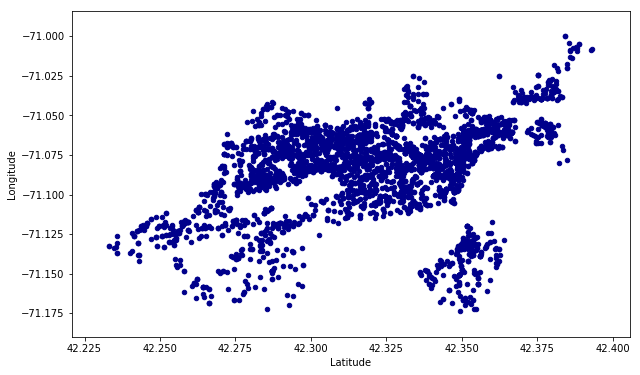

In [12]:
#let us visualize the distributiuon of lattitude longitude in dataset on a scatter plot to see if still there any outliers
bostonCIGeo_df.plot(kind='scatter', x='Latitude', y='Longitude', figsize=(10, 6), color='darkblue')
plt.show()

In [13]:
address = 'Boston, MA'

geolocator = Nominatim(user_agent="ma_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Boston are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Boston are 42.3602534, -71.0582912.


In [14]:
# create map of Boston using latitude and longitude values
map_boston = folium.Map(location=[latitude, longitude], zoom_start=20)

# add markers to map
for lat, lng, offense, street, date in zip(bostonCIGeo_df['Latitude'], bostonCIGeo_df['Longitude'], bostonCIGeo_df['Offense'], bostonCIGeo_df['Street'], bostonCIGeo_df['Date']):
    label = '{} reported on {} at {}'.format(offense,street, date)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_boston)  
    
map_boston

In [25]:
distance((42.362488,-71.056477), (42.3602534,-71.0582912)).km

0.2897409516247836

In [24]:
newport_ri = (41.49008, -71.312796)
cleveland_oh = (41.499498, -81.695391)
print(distance(newport_ri, cleveland_oh).miles)

538.3904451566326


In [14]:
CLIENT_ID = 'GD4ZTRLUGTK50T0TIIL0N5ZYR5LKQ52IKMP33TMFAHYY4IO3' # your Foursquare ID
CLIENT_SECRET = '42HAM3BDY5NELNZBNJJ5T2T2FQOK1DTGJOVR0FXO1KRA1F3E' # your Foursquare Secret
VERSION = '20190220' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: GD4ZTRLUGTK50T0TIIL0N5ZYR5LKQ52IKMP33TMFAHYY4IO3
CLIENT_SECRET:42HAM3BDY5NELNZBNJJ5T2T2FQOK1DTGJOVR0FXO1KRA1F3E


In [15]:
LIMIT = 200 # limit of number of venues returned by Foursquare API
VERSION = 20190220
radius = 10000 # define radius

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=GD4ZTRLUGTK50T0TIIL0N5ZYR5LKQ52IKMP33TMFAHYY4IO3&client_secret=42HAM3BDY5NELNZBNJJ5T2T2FQOK1DTGJOVR0FXO1KRA1F3E&v=20190220&ll=42.3602534,-71.0582912&radius=10000&limit=200'

In [16]:
# make the GET request
results = requests.get(url).json()["response"]['groups'][0]['items']
venues_list=[]
venues_list.append([(
            result['venue']['name'],
            result['venue']['categories'][0]['name'],
            result['venue']['location']['lat'], 
            result['venue']['location']['lng']) for result in results])

bv_df = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
bv_df.columns = ['Name','Category','Latitude','Longitude']
print(bv_df.shape)
bv_df.head()

(100, 4)


Name            Category   Latitude  Longitude
0            North End Park                Park  42.362488 -71.056477
1             Quincy Market       Historic Site  42.360095 -71.054730
2  Faneuil Hall Marketplace       Historic Site  42.359978 -71.056410
3            Sam LaGrassa's      Sandwich Place  42.356870 -71.059960
4           Saus Restaurant  Belgian Restaurant  42.361076 -71.057054

In [17]:
#let us look for duplicates names of venue
bv_df[bv_df.duplicated(['Name'], keep=False)]

Name     Category   Latitude  Longitude
11           sweetgreen  Salad Place  42.357704 -71.058713
31           sweetgreen  Salad Place  42.353943 -71.058550
34  Tatte Bakery & Cafe       Bakery  42.357904 -71.070439
63  Tatte Bakery & Cafe       Bakery  42.351667 -71.071715
84           sweetgreen  Salad Place  42.349933 -71.078625
92  Tatte Bakery & Cafe         Café  42.364978 -71.082849

In [18]:
bv_df.drop_duplicates(subset=['Name'], keep='first', inplace=True)

In [49]:
bv_df[bv_df['Name']=='sweetgreen']

Name     Category   Latitude  Longitude
11  sweetgreen  Salad Place  42.357704 -71.058713

In [50]:
bv_df[bv_df['Name']=='Tatte Bakery & Cafe']

Name Category   Latitude  Longitude
34  Tatte Bakery & Cafe   Bakery  42.357904 -71.070439

In [19]:
def getCrimesNearVenues(vnames, vcategories, vlatitudes, vlongitudes, radius=0.5):
    
    venues_list=[]
    for vname,vcategory,vlat,vlng in zip(vnames, vcategories, vlatitudes, vlongitudes):
        flag=0
        for offense, lat, lng in zip(bostonCIGeo_df['Offense'], bostonCIGeo_df['Latitude'], bostonCIGeo_df['Longitude']):
            if(distance((vlat,vlng), (lat,lng)).km <= radius):
                venues_list.append([(vname, vcategory,vlat,vlng,offense)])
                flag=1
        if(flag == 0):       
            venues_list.append([(vname,vcategory,vlat,vlng,'None')]) 
            
    venues_df = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    venues_df.columns = ['Name','Category','Latitude','Longitude','Offense']
    
    return(venues_df)

In [20]:
bvc_df = getCrimesNearVenues(vnames=bv_df['Name'], vcategories=bv_df['Category'], vlatitudes=bv_df['Latitude'],vlongitudes=bv_df['Longitude'])
print(bvc_df.shape)
bvc_df.head()

(9581, 5)


Name Category   Latitude  Longitude                   Offense
0  North End Park     Park  42.362488 -71.056477        Disorderly Conduct
1  North End Park     Park  42.362488 -71.056477            Simple Assault
2  North End Park     Park  42.362488 -71.056477  Harbor Related Incidents
3  North End Park     Park  42.362488 -71.056477        Aggravated Assault
4  North End Park     Park  42.362488 -71.056477                   Larceny

In [21]:
# one hot encoding
bvconehot_df = pd.get_dummies(bvc_df[['Offense']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
bvconehot_df['Name'] = bvc_df['Name'] 

bvconehotgrp_df=bvconehot_df.groupby('Name').mean().reset_index()

print(bvconehotgrp_df.shape)
bvconehotgrp_df.head()

(96, 35)


Name  Aggravated Assault  \
0       Aquarium Seal Tank            0.018519   
1    Bacco Wine and Cheese            0.042105   
2            Ball and Buck            0.024691   
3       Barcelona Wine Bar            0.019608   
4  Barry's Bootcamp Boston            0.035714   

   Assembly or Gathering Violations  Auto Theft  Bomb Hoax  \
0                          0.000000    0.037037   0.000000   
1                          0.000000    0.031579   0.000000   
2                          0.000000    0.012346   0.006173   
3                          0.000000    0.019608   0.000000   
4                          0.004464    0.000000   0.000000   

   Commercial Burglary  Confidence Games  Counterfeiting  Disorderly Conduct  \
0             0.018519          0.018519        0.000000            0.055556   
1             0.010526          0.010526        0.021053            0.010526   
2             0.024691          0.024691        0.012346            0.012346   
3             0.058824          0.000000        0.000000            0.000000   
4             0.008929          0.013393        0.004464            0.035714   

   Drug Violation  Embezzlement  Evading Fare  Fire Related Reports  \
0        0.000000      0.000000      0.000000              0.000000   
1        0.000000      0.000000      0.010526              0.010526   
2        0.018519      0.000000      0.000000              0.006173   
3        0.000000      0.019608      0.000000              0.039216   
4        0.138393      0.000000      0.000000              0.004464   

   Firearm Discovery  Firearm Violations     Fraud  Harassment  \
0           0.018519            0.000000  0.018519    0.018519   
1           0.010526            0.000000  0.031579    0.000000   
2           0.006173            0.000000  0.043210    0.018519   
3           0.019608            0.000000  0.000000    0.039216   
4           0.000000            0.013393  0.026786    0.000000   

   Harbor Related Incidents   Larceny  Larceny From Motor Vehicle  \
0                  0.018519  0.370370                    0.018519   
1                  0.000000  0.400000                    0.052632   
2                  0.000000  0.506173                    0.055556   
3                  0.000000  0.117647                    0.078431   
4                  0.000000  0.272321                    0.017857   

   License Violation  Liquor Violation  None  Other Burglary  \
0           0.037037          0.000000   0.0        0.018519   
1           0.000000          0.010526   0.0        0.000000   
2           0.000000          0.006173   0.0        0.012346   
3           0.000000          0.000000   0.0        0.000000   
4           0.040179          0.013393   0.0        0.000000   

   Prisoner Related Incidents  Property Lost  Property Related Damage  \
0                         0.0       0.111111                      0.0   
1                         0.0       0.073684                      0.0   
2                         0.0       0.067901                      0.0   
3                         0.0       0.098039                      0.0   
4                         0.0       0.062500                      0.0   

   Residential Burglary  Restraining Order Violations   Robbery  \
0              0.018519                      0.000000  0.000000   
1              0.000000                      0.000000  0.010526   
2              0.000000                      0.000000  0.012346   
3              0.019608                      0.000000  0.019608   
4              0.000000                      0.004464  0.008929   

   Simple Assault  Vandalism  Verbal Disputes  Violations  Warrant Arrests  
0        0.148148   0.037037         0.000000    0.000000         0.018519  
1        0.168421   0.063158         0.010526    0.010526         0.010526  
2        0.074074   0.043210         0.012346    0.000000         0.000000  
3        0.176471   0.156863         0.098039    0.019608         0.000000  
4        0.11607

In [58]:
bvconehotgrp_df[bvconehotgrp_df['Name']=='North End Park']

Cluster Labels            Name  Aggravated Assault  \
60               0  North End Park            0.081081   

    Assembly or Gathering Violations  Auto Theft  Bomb Hoax  \
60                               0.0         0.0   0.006757   

    Commercial Burglary  Confidence Games  Counterfeiting  Disorderly Conduct  \
60              0.02027          0.006757             0.0            0.060811   

    Drug Violation  Embezzlement  Evading Fare  Fire Related Reports  \
60        0.094595           0.0           0.0              0.006757   

    Firearm Discovery  Firearm Violations     Fraud  Harassment  \
60           0.006757            0.006757  0.047297    0.006757   

    Harbor Related Incidents   Larceny  Larceny From Motor Vehicle  \
60                  0.006757  0.216216                    0.006757   

    License Violation  Liquor Violation  Other Burglary  \
60           0.027027               0.0        0.013514   

    Prisoner Related Incidents  Property Lost  Property Related Damage  \
60                         0.0       0.135135                      0.0   

    Residential Burglary  Restraining Order Violations  Robbery  \
60              0.006757                           0.0      0.0   

    Simple Assault  Vandalism  Verbal Disputes  Violations  Warrant Arrests  \
60        0.135135   0.027027              0.0         0.0         0.081081   

    none  
60   0.0

In [22]:
kclusters = 10

bvclustering_df = bvconehotgrp_df.drop('Name', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(bvclustering_df)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([7, 7, 3, 9, 8, 9, 3, 7, 8, 7], dtype=int32)

In [23]:
bvconehotgrp_df.insert(0, 'Cluster Labels', kmeans.labels_)

bvmerged_df = bv_df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
bvmerged_df = bvmerged_df.join(bvconehotgrp_df.set_index('Name'), on='Name')

bvmerged_df.head() # check the last columns!

Name            Category   Latitude  Longitude  \
0            North End Park                Park  42.362488 -71.056477   
1             Quincy Market       Historic Site  42.360095 -71.054730   
2  Faneuil Hall Marketplace       Historic Site  42.359978 -71.056410   
3            Sam LaGrassa's      Sandwich Place  42.356870 -71.059960   
4           Saus Restaurant  Belgian Restaurant  42.361076 -71.057054   

   Cluster Labels  Aggravated Assault  Assembly or Gathering Violations  \
0               0            0.081081                          0.000000   
1               0            0.045455                          0.000000   
2               0            0.050955                          0.000000   
3               7            0.035714                          0.005952   
4               0            0.077419                          0.000000   

   Auto Theft  Bomb Hoax  Commercial Burglary  Confidence Games  \
0    0.000000   0.006757             0.020270          0.006757   
1    0.015152   0.007576             0.015152          0.015152   
2    0.000000   0.006369             0.025478          0.006369   
3    0.000000   0.005952             0.011905          0.011905   
4    0.000000   0.006452             0.019355          0.006452   

   Counterfeiting  Disorderly Conduct  Drug Violation  Embezzlement  \
0        0.000000            0.060811        0.094595           0.0   
1        0.000000            0.060606        0.090909           0.0   
2        0.000000            0.050955        0.076433           0.0   
3        0.005952            0.035714        0.035714           0.0   
4        0.000000            0.070968        0.083871           0.0   

   Evading Fare  Fire Related Reports  Firearm Discovery  Firearm Violations  \
0           0.0              0.006757           0.006757            0.006757   
1           0.0              0.007576           0.007576            0.007576   
2           0.0              0.006369           0.006369            0.006369   
3           0.0              0.005952           0.000000            0.005952   
4           0.0              0.006452           0.006452            0.006452   

      Fraud  Harassment  Harbor Related Incidents   Larceny  \
0  0.047297    0.006757                  0.006757  0.216216   
1  0.037879    0.007576                  0.007576  0.219697   
2  0.050955    0.006369                  0.006369  0.242038   
3  0.029762    0.005952                  0.000000  0.333333   
4  0.051613    0.006452                  0.006452  0.193548   

   Larceny From Motor Vehicle  License Violation  Liquor Violation  None  \
0                    0.006757           0.027027          0.000000   0.0   
1                    0.000000           0.030303          0.000000   0.0   
2                    0.000000           0.019108          0.000000   0.0   
3                    0.005952           0.011905          0.017857   0.0   
4                    0.006452           0.019355          0.000000   0.0   

   Other Burglary  Prisoner Related Incidents  Property Lost  \
0        0.013514                         0.0       0.135135   
1        0.015152                         0.0       0.136364   
2        0.012739                         0.0       0.133758   
3        0.000000                         0.0       0.107143   
4        0.012903                         0.0       0.135484   

   Property Related Damage  Residential Burglary  \
0                      0.0              0.006757   
1                      0.0              0.015152   
2                      0.0              0.012739   
3                      0.0              0.000000   
4                      0.0              0.006452   

   Restraining Order Violations   Robbery  Simple Assault  Vandalism  \
0                           0.0  0.000000        0.135135   0.027027   
1                           0.0  0.000000        0.136364   0.030303   
2                           0.0  0.000000        0.146497   0.031847   


In [46]:
from folium import IFrame
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=15)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat,lon,name,cat,cluster in zip(bvmerged_df['Latitude'], bvmerged_df['Longitude'],bvmerged_df['Name'], bvmerged_df['Category'], bvmerged_df['Cluster Labels']):
    htmlLabel='<html><span style="text-decoration: underline;"><strong>Group: '+ str(cluster) + '</strong></span><br/><span style="text-decoration: underline;">Category:</span> '+ str(cat)+', <span style="text-decoration: underline;">Name:</span> '+  str(name) + '</html>'
    iframe = IFrame(html=htmlLabel, width=250, height=75)
    popup = folium.Popup(iframe, max_width=2650)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=popup,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters


In [80]:
import matplotlib as mpl
import matplotlib.cm as cm

norm = mpl.colors.Normalize(vmin=-20, vmax=20)
cmap = cm.Purples

m = cm.ScalarMappable(norm=norm, cmap=cmap)
colors.rgb2hex(m.to_rgba(1))

'#7262ac'

In [82]:

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
ys

[array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([ 1,  3,  7, 13, 21, 31, 43, 57, 73, 91]),
 array([  2,   7,  20,  41,  70, 107, 152, 205, 266, 335]),
 array([  3,  13,  41,  87, 151, 233, 333, 451, 587, 741]),
 array([   4,   21,   70,  151,  264,  409,  586,  795, 1036, 1309]),
 array([   5,   31,  107,  233,  409,  635,  911, 1237, 1613, 2039]),
 array([   6,   43,  152,  333,  586,  911, 1308, 1777, 2318, 2931]),
 array([   7,   57,  205,  451,  795, 1237, 1777, 2415, 3151, 3985]),
 array([   8,   73,  266,  587, 1036, 1613, 2318, 3151, 4112, 5201]),
 array([   9,   91,  335,  741, 1309, 2039, 2931, 3985, 5201, 6579])]

In [48]:
bvmerged_df.loc[bvmerged_df['Cluster Labels'] == 0, bvmerged_df.columns[[0] + [1] + list(range(5, bvmerged_df.shape[1]))]]

Name            Category  Aggravated Assault  \
0              North End Park                Park            0.081081   
1               Quincy Market       Historic Site            0.045455   
2    Faneuil Hall Marketplace       Historic Site            0.050955   
4             Saus Restaurant  Belgian Restaurant            0.077419   
5              Neptune Oyster  Seafood Restaurant            0.093023   
7        Boston Public Market              Market            0.081081   
10                Ghirardelli      Chocolate Shop            0.048276   
11                 sweetgreen         Salad Place            0.035874   
12                     Grotto  Italian Restaurant            0.033557   
13            Regina Pizzeria         Pizza Place            0.099099   
15  Christopher Columbus Park                Park            0.075949   
18           Monica's Mercato              Market            0.123288   
19                     Locale         Pizza Place            0.142857   
20               Little Italy        Neighborhood            0.071429   
24                     Prezza  Italian Restaurant            0.133333   
25                  TD Garden        Hockey Arena            0.132075   
26       The Old North Church              Church            0.119048   
61         Whole Foods Market       Grocery Store            0.088235   

    Assembly or Gathering Violations  Auto Theft  Bomb Hoax  \
0                           0.000000    0.000000   0.006757   
1                           0.000000    0.015152   0.007576   
2                           0.000000    0.000000   0.006369   
4                           0.000000    0.000000   0.006452   
5                           0.000000    0.000000   0.000000   
7                           0.000000    0.000000   0.006757   
10                          0.000000    0.013793   0.006897   
11                          0.004484    0.000000   0.004484   
12                          0.000000    0.006711   0.006711   
13                          0.000000    0.000000   0.000000   
15                          0.000000    0.025316   0.000000   
18                          0.000000    0.000000   0.000000   
19                          0.000000    0.000000   0.000000   
20                          0.000000    0.000000   0.000000   
24                          0.000000    0.000000   0.000000   
25                          0.000000    0.000000   0.000000   
26                          0.000000    0.000000   0.000000   
61                          0.000000    0.029412   0.000000   

    Commercial Burglary  Confidence Games  Counterfeiting  Disorderly Conduct  \
0              0.020270          0.006757        0.000000            0.060811   
1              0.015152          0.015152        0.000000            0.060606   
2              0.025478          0.006369        0.000000            0.050955   
4              0.019355          0.006452        0.000000            0.070968   
5              0.023256          0.007752        0.000000            0.054264   
7              0.020270          0.013514        0.000000            0.060811   
10             0.013793          0.013793        0.000000            0.055172   
11             0.013453          0.013453        0.004484            0.044843   
12             0.013423          0.020134        0.000000            0.046980   
13             0.027027          0.009009        0.000000            0.081081   
15             0.037975          0.025316        0.000000            0.075949   
18             0.054795          0.013699        0.000000            0.082192   
19             0.047619          0.023810        0.000000            0.047619   
20             0.026786          0.008929        0.000000            0.053571   
24             0.066667          0.022222        0.000000            0.044444   
25             0.018868          0.018868        0.000000            0.113208   
26             0.071429          0.000000        0.000000     

In [51]:
bvmerged_df.loc[bvmerged_df['Cluster Labels'] == 1, bvmerged_df.columns[[0] + [1] + list(range(5, bvmerged_df.shape[1]))]]

Name Category  Aggravated Assault  \
79  Tatte Bakery & Café   Bakery                 0.0   

    Assembly or Gathering Violations  Auto Theft  Bomb Hoax  \
79                               0.0         0.0        0.0   

    Commercial Burglary  Confidence Games  Counterfeiting  Disorderly Conduct  \
79                  0.0               0.0             0.0                 0.0   

    Drug Violation  Embezzlement  Evading Fare  Fire Related Reports  \
79             0.0           0.0           0.0                   0.0   

    Firearm Discovery  Firearm Violations  Fraud  Harassment  \
79                0.0                 0.0    0.0         0.0   

    Harbor Related Incidents  Larceny  Larceny From Motor Vehicle  \
79                       0.0      0.0                         0.0   

    License Violation  Liquor Violation  None  Other Burglary  \
79                0.0               0.0   1.0             0.0   

    Prisoner Related Incidents  Property Lost  Property Related Damage  \
79                         0.0            0.0                      0.0   

    Residential Burglary  Restraining Order Violations  Robbery  \
79                   0.0                           0.0      0.0   

    Simple Assault  Vandalism  Verbal Disputes  Violations  Warrant Arrests  
79             0.0        0.0              0.0         0.0              0.0

In [57]:
bvmerged_df.loc[bvmerged_df['Cluster Labels'] == 2, bvmerged_df.columns[[0] + [1] + list(range(5, bvmerged_df.shape[1]))]]

Name           Category  Aggravated Assault  \
34     Tatte Bakery & Cafe             Bakery            0.025641   
38       The Liberty Hotel              Hotel            0.035714   
39  J.P. Licks Beacon Hill     Ice Cream Shop            0.027027   
41  Make Way For Ducklings  Outdoor Sculpture            0.021739   
43           The Esplanade               Park            0.000000   
46           The Paramount     Breakfast Spot            0.027027   

    Assembly or Gathering Violations  Auto Theft  Bomb Hoax  \
34                               0.0    0.051282        0.0   
38                               0.0    0.035714        0.0   
39                               0.0    0.027027        0.0   
41                               0.0    0.065217        0.0   
43                               0.0    0.026316        0.0   
46                               0.0    0.054054        0.0   

    Commercial Burglary  Confidence Games  Counterfeiting  Disorderly Conduct  \
34             0.000000          0.000000        0.000000                 0.0   
38             0.035714          0.000000        0.000000                 0.0   
39             0.027027          0.000000        0.000000                 0.0   
41             0.000000          0.000000        0.021739                 0.0   
43             0.000000          0.026316        0.000000                 0.0   
46             0.000000          0.000000        0.000000                 0.0   

    Drug Violation  Embezzlement  Evading Fare  Fire Related Reports  \
34             0.0           0.0           0.0                   0.0   
38             0.0           0.0           0.0                   0.0   
39             0.0           0.0           0.0                   0.0   
41             0.0           0.0           0.0                   0.0   
43             0.0           0.0           0.0                   0.0   
46             0.0           0.0           0.0                   0.0   

    Firearm Discovery  Firearm Violations     Fraud  Harassment  \
34                0.0                 0.0  0.051282         0.0   
38                0.0                 0.0  0.071429         0.0   
39                0.0                 0.0  0.054054         0.0   
41                0.0                 0.0  0.065217         0.0   
43                0.0                 0.0  0.052632         0.0   
46                0.0                 0.0  0.054054         0.0   

    Harbor Related Incidents   Larceny  Larceny From Motor Vehicle  \
34                       0.0  0.076923                    0.358974   
38                       0.0  0.071429                    0.357143   
39                       0.0  0.108108                    0.324324   
41                       0.0  0.173913                    0.304348   
43                       0.0  0.184211                    0.342105   
46                       0.0  0.081081                    0.378378   

    License Violation  Liquor Violation  None  Other Burglary  \
34                0.0               0.0   0.0             0.0   
38                0.0               0.0   0.0             0.0   
39                0.0               0.0   0.0             0.0   
41                0.0               0.0   0.0             0.0   
43                0.0               0.0   0.0             0.0   
46                0.0               0.0   0.0             0.0   

    Prisoner Related Incidents  Property Lost  Property Related Damage  \
34                         0.0       0.051282                      0.0   
38                         0.0       0.107143                      0.0   
39                         0.0       0.081081                      0.0   
41                         0.0       0.021739                      0.0   
43                         0.0       0.026316                      0.0   
46                         0.0       0.054054                      0.0   

    Residential Burglary  Restraining Order Violations  Robbery  \
34              0.02

In [49]:
bvmerged_df.loc[bvmerged_df['Cluster Labels'] == 3, bvmerged_df.columns[[0] + [1] + list(range(5, bvmerged_df.shape[1]))]]

Name                 Category  \
14                         Yvonne's  New American Restaurant   
16                    Boston Common                     Park   
21          Barry's Bootcamp Boston     Gym / Fitness Center   
29                        Frog Pond                     Lake   
33               Boston Opera House              Opera House   
35       Equinox Sports Club Boston                      Gym   
36                       Caffè Nero              Coffee Shop   
40                 Gracenote Coffee              Coffee Shop   
42                        Shabu Zen         Asian Restaurant   
47          Cutler Majestic Theatre                  Theater   
48  Hostelling International Boston                   Hostel   
50                      Boch Center                  Theater   
57                            Ostra       Seafood Restaurant   
71                    Brewer's Fork                Gastropub   
73             Bunker Hill Monument      Monument / Landmark   

    Aggravated Assault  Assembly or Gathering Violations  Auto Theft  \
14            0.032407                          0.004630    0.000000   
16            0.033816                          0.004831    0.004831   
21            0.035714                          0.004464    0.000000   
29            0.040936                          0.005848    0.005848   
33            0.038462                          0.004274    0.000000   
35            0.050420                          0.004202    0.000000   
36            0.042373                          0.004237    0.000000   
40            0.038217                          0.000000    0.000000   
42            0.062147                          0.000000    0.000000   
47            0.058394                          0.007299    0.007299   
48            0.059524                          0.005952    0.000000   
50            0.053846                          0.000000    0.007692   
57            0.041667                          0.000000    0.008333   
71            0.023256                          0.023256    0.000000   
73            0.025000                          0.025000    0.000000   

    Bomb Hoax  Commercial Burglary  Confidence Games  Counterfeiting  \
14    0.00463             0.009259          0.013889        0.004630   
16    0.00000             0.009662          0.009662        0.004831   
21    0.00000             0.008929          0.013393        0.004464   
29    0.00000             0.005848          0.011696        0.000000   
33    0.00000             0.008547          0.017094        0.004274   
35    0.00000             0.004202          0.016807        0.004202   
36    0.00000             0.004237          0.016949        0.004237   
40    0.00000             0.000000          0.012739        0.006369   
42    0.00000             0.000000          0.011299        0.005650   
47    0.00000             0.000000          0.014599        0.007299   
48    0.00000             0.000000          0.011905        0.000000   
50    0.00000             0.000000          0.015385        0.007692   
57    0.00000             0.008333          0.016667        0.008333   
71    0.00000             0.000000          0.023256        0.023256   
73    0.00000             0.000000          0.025000        0.000000   

    Disorderly Conduct  Drug Violation  Embezzlement  Evading Fare  \
14            0.032407        0.143519           0.0      0.000000   
16            0.033816        0.140097           0.0      0.000000   
21            0.035714        0.138393           0.0      0.000000   
29            0.029240        0.134503           0.0      0.000000   
33            0.034188        0.136752           0.0      0.000000   
35            0.033613        0.134454           0.0      0.000000   
36            0.033898        0.135593           0.0      0.000000   
40            0.025478        0.191083           0.0      0.000000   
42            0.022599        0.169492           0.0      0.000000   


In [52]:
bvmerged_df.loc[bvmerged_df['Cluster Labels'] == 4, bvmerged_df.columns[[0] + [1] + list(range(5, bvmerged_df.shape[1]))]]

Name Category  Aggravated Assault  \
91  Downeast Cider House  Brewery                 0.0   

    Assembly or Gathering Violations  Auto Theft  Bomb Hoax  \
91                               0.0         0.5        0.0   

    Commercial Burglary  Confidence Games  Counterfeiting  Disorderly Conduct  \
91                  0.0               0.0             0.0                 0.0   

    Drug Violation  Embezzlement  Evading Fare  Fire Related Reports  \
91             0.0           0.0           0.0                   0.0   

    Firearm Discovery  Firearm Violations  Fraud  Harassment  \
91                0.0                 0.0    0.0         0.0   

    Harbor Related Incidents  Larceny  Larceny From Motor Vehicle  \
91                       0.0      0.0                         0.0   

    License Violation  Liquor Violation  None  Other Burglary  \
91                0.0               0.0   0.0             0.0   

    Prisoner Related Incidents  Property Lost  Property Related Damage  \
91                         0.0            0.0                      0.0   

    Residential Burglary  Restraining Order Violations  Robbery  \
91                   0.5                           0.0      0.0   

    Simple Assault  Vandalism  Verbal Disputes  Violations  Warrant Arrests  
91             0.0        0.0              0.0         0.0              0.0

In [50]:
bvmerged_df.loc[bvmerged_df['Cluster Labels'] == 5, bvmerged_df.columns[[0] + [1] + list(range(5, bvmerged_df.shape[1]))]]

Name Category  Aggravated Assault  \
52  Charles River    River                 0.0   

    Assembly or Gathering Violations  Auto Theft  Bomb Hoax  \
52                               0.0         0.0        0.0   

    Commercial Burglary  Confidence Games  Counterfeiting  Disorderly Conduct  \
52                  0.0               0.0             0.0                 0.0   

    Drug Violation  Embezzlement  Evading Fare  Fire Related Reports  \
52             0.0           0.0           0.0                   0.0   

    Firearm Discovery  Firearm Violations  Fraud  Harassment  \
52                0.0                 0.0    0.0         0.0   

    Harbor Related Incidents  Larceny  Larceny From Motor Vehicle  \
52                       0.0      0.0                    0.333333   

    License Violation  Liquor Violation  None  Other Burglary  \
52                0.0               0.0   0.0             0.0   

    Prisoner Related Incidents  Property Lost  Property Related Damage  \
52                         0.0            0.0                      0.0   

    Residential Burglary  Restraining Order Violations  Robbery  \
52                   0.0                           0.0      0.0   

    Simple Assault  Vandalism  Verbal Disputes  Violations  Warrant Arrests  
52        0.666667        0.0              0.0         0.0              0.0

In [53]:
bvmerged_df.loc[bvmerged_df['Cluster Labels'] == 6, bvmerged_df.columns[[0] + [1] + list(range(5, bvmerged_df.shape[1]))]]

Name            Category  Aggravated Assault  \
28      James Hook & Company  Seafood Restaurant            0.000000   
44  Boston Children's Museum              Museum            0.000000   
49       Flour Bakery & Cafe              Bakery            0.000000   
53  Trillium Brewing Company             Brewery            0.000000   
54                    Row 34  Seafood Restaurant            0.000000   
56                    Lolita  Mexican Restaurant            0.000000   
58            Mike & Patty's      Sandwich Place            0.065789   
60                     Drink        Cocktail Bar            0.000000   
78                Piers Park                Park            0.000000   

    Assembly or Gathering Violations  Auto Theft  Bomb Hoax  \
28                               0.0    0.058824        0.0   
44                               0.0    0.045455        0.0   
49                               0.0    0.047619        0.0   
53                               0.0    0.050000        0.0   
54                               0.0    0.052632        0.0   
56                               0.0    0.055556        0.0   
58                               0.0    0.026316        0.0   
60                               0.0    0.050000        0.0   
78                               0.0    0.142857        0.0   

    Commercial Burglary  Confidence Games  Counterfeiting  Disorderly Conduct  \
28             0.000000          0.029412        0.029412            0.058824   
44             0.000000          0.045455        0.045455            0.000000   
49             0.000000          0.047619        0.047619            0.000000   
53             0.000000          0.050000        0.050000            0.000000   
54             0.000000          0.052632        0.052632            0.000000   
56             0.000000          0.000000        0.055556            0.000000   
58             0.013158          0.013158        0.013158            0.013158   
60             0.000000          0.050000        0.050000            0.000000   
78             0.000000          0.142857        0.000000            0.000000   

    Drug Violation  Embezzlement  Evading Fare  Fire Related Reports  \
28        0.000000           0.0      0.000000              0.000000   
44        0.000000           0.0      0.000000              0.000000   
49        0.000000           0.0      0.000000              0.000000   
53        0.000000           0.0      0.000000              0.000000   
54        0.000000           0.0      0.000000              0.000000   
56        0.000000           0.0      0.000000              0.000000   
58        0.013158           0.0      0.013158              0.039474   
60        0.000000           0.0      0.000000              0.000000   
78        0.000000           0.0      0.000000              0.000000   

    Firearm Discovery  Firearm Violations     Fraud  Harassment  \
28           0.000000                 0.0  0.058824         0.0   
44           0.000000                 0.0  0.045455         0.0   
49           0.000000                 0.0  0.047619         0.0   
53           0.000000                 0.0  0.050000         0.0   
54           0.052632                 0.0  0.000000         0.0   
56           0.000000                 0.0  0.055556         0.0   
58           0.000000                 0.0  0.026316         0.0   
60           0.000000                 0.0  0.050000         0.0   
78           0.000000                 0.0  0.000000         0.0   

    Harbor Related Incidents   Larceny  Larceny From Motor Vehicle  \
28                       0.0  0.264706                    0.029412   
44                       0.0  0.227273                    0.045455   
49                       0.0  0.190476                    0.047619   
53                       0.0  0.200000                    0.050000   
54                       0.0  0.210526                    0.052632   
56                       0.0  0.222222           

In [54]:
bvmerged_df.loc[bvmerged_df['Cluster Labels'] == 7, bvmerged_df.columns[[0] + [1] + list(range(5, bvmerged_df.shape[1]))]]

Name                       Category  \
3                    Sam LaGrassa's                 Sandwich Place   
6                  Boston Athenaeum                        Library   
8         The Rose Kennedy Greenway                           Park   
9                 The Freedom Trail                  Historic Site   
17  Trillium Garden On The Greenway                    Beer Garden   
22         The Langham Boston Hotel                          Hotel   
23                    Kane's Donuts                     Donut Shop   
27               Aquarium Seal Tank                       Aquarium   
30                Boston Harborwalk                          Trail   
32              Clover Food Lab FIN  Vegetarian / Vegan Restaurant   
37             Boston Public Garden                         Garden   
45        Four Seasons Hotel Boston                          Hotel   
55                   Bistro du Midi              French Restaurant   
59               YogaWorks Back Bay                    Yoga Studio   
62                Parish Cafe & Bar                 Sandwich Place   
64            Bacco Wine and Cheese                      Wine Shop   
65                    Btone Fitness                            Gym   
66               Georgetown Cupcake                   Cupcake Shop   
67                     Thinking Cup                    Coffee Shop   
68              Flour Bakery + Cafe                         Bakery   
69                   Grill 23 & Bar                     Steakhouse   
74                          Mistral              French Restaurant   
75           L.A. Burdick Chocolate                   Dessert Shop   
77                      Urban Grape                      Wine Shop   
81               The Friendly Toast                 Breakfast Spot   
99                            Douzo               Sushi Restaurant   

    Aggravated Assault  Assembly or Gathering Violations  Auto Theft  \
3             0.035714                          0.005952    0.000000   
6             0.036145                          0.006024    0.006024   
8             0.033333                          0.000000    0.033333   
9             0.036364                          0.006061    0.000000   
17            0.017857                          0.000000    0.035714   
22            0.024793                          0.000000    0.016529   
23            0.015873                          0.000000    0.031746   
27            0.018519                          0.000000    0.037037   
30            0.057971                          0.000000    0.028986   
32            0.029412                          0.000000    0.000000   
37            0.012987                          0.000000    0.025974   
45            0.040816                          0.000000    0.010204   
55            0.040816                          0.000000    0.020408   
59            0.022727                          0.000000    0.045455   
62            0.022989                          0.000000    0.045977   
64            0.042105                          0.000000    0.031579   
65            0.022222                          0.000000    0.044444   
66            0.030928                          0.000000    0.041237   
67            0.030928                          0.000000    0.041237   
68            0.026316                          0.000000    0.026316   
69            0.021978                          0.000000    0.032967   
74            0.035398                          0.000000    0.026549   
75            0.023810                          0.000000    0.031746   
77            0.030303                          0.000000    0.020202   
81            0.026786                          0.000000    0.026786   
99            0.026316                          0.000000    0.017544   

    Bomb Hoax  Commercial Burglary  Confidence Games  Counterfeiting  \
3    0.005952             0.011905          0.011905        0.005952   
6    0.006024             0.012048          0.01204

In [55]:
bvmerged_df.loc[bvmerged_df['Cluster Labels'] == 8, bvmerged_df.columns[[0] + [1] + list(range(5, bvmerged_df.shape[1]))]]

Name                 Category  \
14                         Yvonne's  New American Restaurant   
16                    Boston Common                     Park   
21          Barry's Bootcamp Boston     Gym / Fitness Center   
29                        Frog Pond                     Lake   
33               Boston Opera House              Opera House   
35       Equinox Sports Club Boston                      Gym   
36                       Caffè Nero              Coffee Shop   
40                 Gracenote Coffee              Coffee Shop   
42                        Shabu Zen         Asian Restaurant   
47          Cutler Majestic Theatre                  Theater   
48  Hostelling International Boston                   Hostel   
50                      Boch Center                  Theater   
57                            Ostra       Seafood Restaurant   
71                    Brewer's Fork                Gastropub   
73             Bunker Hill Monument      Monument / Landmark   

    Aggravated Assault  Assembly or Gathering Violations  Auto Theft  \
14            0.032407                          0.004630    0.000000   
16            0.033816                          0.004831    0.004831   
21            0.035714                          0.004464    0.000000   
29            0.040936                          0.005848    0.005848   
33            0.038462                          0.004274    0.000000   
35            0.050420                          0.004202    0.000000   
36            0.042373                          0.004237    0.000000   
40            0.038217                          0.000000    0.000000   
42            0.062147                          0.000000    0.000000   
47            0.058394                          0.007299    0.007299   
48            0.059524                          0.005952    0.000000   
50            0.053846                          0.000000    0.007692   
57            0.041667                          0.000000    0.008333   
71            0.023256                          0.023256    0.000000   
73            0.025000                          0.025000    0.000000   

    Bomb Hoax  Commercial Burglary  Confidence Games  Counterfeiting  \
14    0.00463             0.009259          0.013889        0.004630   
16    0.00000             0.009662          0.009662        0.004831   
21    0.00000             0.008929          0.013393        0.004464   
29    0.00000             0.005848          0.011696        0.000000   
33    0.00000             0.008547          0.017094        0.004274   
35    0.00000             0.004202          0.016807        0.004202   
36    0.00000             0.004237          0.016949        0.004237   
40    0.00000             0.000000          0.012739        0.006369   
42    0.00000             0.000000          0.011299        0.005650   
47    0.00000             0.000000          0.014599        0.007299   
48    0.00000             0.000000          0.011905        0.000000   
50    0.00000             0.000000          0.015385        0.007692   
57    0.00000             0.008333          0.016667        0.008333   
71    0.00000             0.000000          0.023256        0.023256   
73    0.00000             0.000000          0.025000        0.000000   

    Disorderly Conduct  Drug Violation  Embezzlement  Evading Fare  \
14            0.032407        0.143519           0.0      0.000000   
16            0.033816        0.140097           0.0      0.000000   
21            0.035714        0.138393           0.0      0.000000   
29            0.029240        0.134503           0.0      0.000000   
33            0.034188        0.136752           0.0      0.000000   
35            0.033613        0.134454           0.0      0.000000   
36            0.033898        0.135593           0.0      0.000000   
40            0.025478        0.191083           0.0      0.000000   
42            0.022599        0.169492           0.0      0.000000   


In [56]:
bvmerged_df.loc[bvmerged_df['Cluster Labels'] == 9, bvmerged_df.columns[[0] + [1] + list(range(5, bvmerged_df.shape[1]))]]

Name             Category  Aggravated Assault  \
51   Museum of Science       Science Museum            0.000000   
82               Coppa   Italian Restaurant            0.017241   
83               Picco          Pizza Place            0.019608   
85       Myers + Chang   Chinese Restaurant            0.025000   
87           Polka Dog            Pet Store            0.017241   
94  Barcelona Wine Bar             Wine Bar            0.019608   
95             Beehive  American Restaurant            0.019608   
96       Oishii Boston  Japanese Restaurant            0.000000   

    Assembly or Gathering Violations  Auto Theft  Bomb Hoax  \
51                               0.0    0.000000        0.0   
82                               0.0    0.017241        0.0   
83                               0.0    0.019608        0.0   
85                               0.0    0.025000        0.0   
87                               0.0    0.017241        0.0   
94                               0.0    0.019608        0.0   
95                               0.0    0.019608        0.0   
96                               0.0    0.026316        0.0   

    Commercial Burglary  Confidence Games  Counterfeiting  Disorderly Conduct  \
51             0.200000               0.0             0.0                 0.0   
82             0.017241               0.0             0.0                 0.0   
83             0.019608               0.0             0.0                 0.0   
85             0.025000               0.0             0.0                 0.0   
87             0.017241               0.0             0.0                 0.0   
94             0.058824               0.0             0.0                 0.0   
95             0.058824               0.0             0.0                 0.0   
96             0.026316               0.0             0.0                 0.0   

    Drug Violation  Embezzlement  Evading Fare  Fire Related Reports  \
51        0.000000      0.000000           0.0              0.000000   
82        0.034483      0.017241           0.0              0.034483   
83        0.019608      0.000000           0.0              0.039216   
85        0.025000      0.025000           0.0              0.050000   
87        0.034483      0.017241           0.0              0.034483   
94        0.000000      0.019608           0.0              0.039216   
95        0.000000      0.019608           0.0              0.019608   
96        0.026316      0.026316           0.0              0.052632   

    Firearm Discovery  Firearm Violations     Fraud  Harassment  \
51           0.000000                 0.0  0.000000    0.000000   
82           0.017241                 0.0  0.086207    0.034483   
83           0.019608                 0.0  0.019608    0.039216   
85           0.000000                 0.0  0.100000    0.000000   
87           0.017241                 0.0  0.086207    0.034483   
94           0.019608                 0.0  0.000000    0.039216   
95           0.019608                 0.0  0.019608    0.039216   
96           0.000000                 0.0  0.105263    0.000000   

    Harbor Related Incidents   Larceny  Larceny From Motor Vehicle  \
51                       0.0  0.200000                    0.000000   
82                       0.0  0.155172                    0.068966   
83                       0.0  0.137255                    0.078431   
85                       0.0  0.225000                    0.025000   
87                       0.0  0.155172                    0.068966   
94                       0.0  0.117647                    0.078431   
95                       0.0  0.117647                    0.098039   
96                       0.0  0.236842                    0.026316   

    License Violation  Liquor Violation  None  Other Burglary  \
51                0.0               0.0   0.0             0.0   
82                0.0               0.0   0.0             0.0   
83                0.0               0